In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
H = np.loadtxt("Hmatrix2.txt",delimiter=',')
Axes0 = H.shape[0] #Rows
Axes1 = H.shape[1] #Cols
print(Axes0,Axes1)
# print(H)

3000 5000


In [16]:
class Node:
    def __init__(self, nodeID, connected_nodeList, bitValue,*args,**kwargs): 
        self.nodeID = nodeID #Helps to locate node in general list
        self.adjNodes = connected_nodeList # List of connected nodes to a particular node
        self.prevMsg = 2 #Set 2 as there is no initial messsage when started
        self.currMsg = bitValue
        self.pr1 = 0.5 if bitValue==-1 else bitValue #Stores probab=0.5 for erasure else same as bit.
        self.FrmAdjNode = [None]*len(connected_nodeList) #Msg received from adj nodes


    def varToChk(self,chkNodes):
        if self.prevMsg==2:
            # print("First Iteration\n")
            for nodeInd in self.adjNodes: # From variable nodes adjacent node list 
                idInd = chkNodes[nodeInd].adjNodes.index(self.nodeID) #Index of checknodes in chkNodes list
                chkNodes[nodeInd].FrmAdjNode[idInd] = self.pr1
                # print("ChkNodeID: ",chkNodes[nodeInd].nodeID, chkNodes[nodeInd].adjNodes," ProbabList: ",chkNodes[nodeInd].FrmAdjNode)
            self.prevMsg = self.currMsg
        else:
            # print("2+ Iteration\n")
            self.prevMsg = self.currMsg
            for i in range(len(self.adjNodes)):
                pr1 = float(self.pr1)
                # print(pr1)
                pr0 = 1 - pr1
                # print(f"\npr1:{pr1} ProbabList: ",self.FrmAdjNode)
                for j in range(len(self.FrmAdjNode)): #Iterate through probab list sent by chk nodes
                    if  i == j:
                        continue
                    else:
                        prob1 = self.FrmAdjNode[j]
                        # print(prob1)
                        pr1 = pr1*prob1
                        pr0 = pr0*(1 - prob1)

                if(pr0 == 0 and pr1==0):
                    pr0 = pr1 = 0.000001
                k = 1/(pr0 + pr1)
                
                chkNodeInd = self.adjNodes[i]
                varNodeInd = chkNodes[chkNodeInd].adjNodes.index(self.nodeID)
                chkNodes[chkNodeInd].FrmAdjNode[varNodeInd] = k*pr1
                # print("ChkNodeID: ",chkNodes[chkNodeInd].nodeID, chkNodes[chkNodeInd].adjNodes,f" k: {k} ")

            new_pr1 = self.pr1
            new_pr0 = 1 - self.pr1
            # print("VarBeleif: ",new_pr0,new_pr1)
            for prob in self.FrmAdjNode:
                new_pr1*=prob
                new_pr0*=(1-prob)
            
            # if(new_pr0 == 0 and new_pr1==0):
            #     new_pr0 = new_pr1 = 0.000001
            k_1 = 1/(new_pr0 + new_pr1)
            # # print("M2: ",new_pr0,new_pr1)
            new_pr0*=k_1
            new_pr1*=k_1
            self.pr1 = new_pr1
            # print(self.nodeID, " P(1): ",new_pr1," P(0): ",new_pr0)
            # if self.currMsg==-1:
            if(new_pr1 > new_pr0):
                self.currMsg = 1
            elif (new_pr0 > new_pr1):
                self.currMsg = 0
            else:
                self.currMsg = -1
                

    def chkToVar(self,varNodes):
        for i in range(len(self.adjNodes)):
            prob0 = 0.5
            for j in range(len(self.FrmAdjNode)): #Iterate through probab list sent by var nodes
                if i == j:
                    continue
                else:
                    pr1 = self.FrmAdjNode[j]
                    prob0 = prob0*(1-2*pr1)
                    
            varNodeInd = self.adjNodes[i]
            chknodeInd = varNodes[varNodeInd].adjNodes.index(self.nodeID)
            varNodes[varNodeInd].FrmAdjNode[chknodeInd] = 0.5 - prob0 #1-(0.5+0.5*(1-2qi'j))
            # print("VarNodeID: ",varNodes[varNodeInd].nodeID, varNodes[varNodeInd].adjNodes," ProbabList: ",varNodes[varNodeInd].FrmAdjNode)


In [17]:
def soft_decode_bec(varNodes,chkNodes):
    t = 0 #Iteration index
    errorList = [0]*50

    while(t<50):
        # print(f"Iteration {t}")
        #variable node to check node logic
        for varNode in varNodes:
            # print(f"Var{varNode.nodeID} with bit prob:{varNode.pr1} to chk\n")
            varNode.varToChk(chkNodes)

        #check node to variable node logic
        for chkNode in chkNodes:
            # print(f"chk{chkNode.nodeID} to Var\n")
            chkNode.chkToVar(varNodes)
            
                
        #Loop break condition and error counting
        currWord = []
        errCnt = 0
        for parity in varNodes:
            msg = parity.currMsg
            if msg == -1:
                errCnt+=1
            currWord.append(msg)
        # print(f"{t}_th Iter: ",currWord,errCnt)
        errorList[t] = (errCnt/len(currWord))

        
        # if -1 not in currWord:
        #     # print(currWord)
        #     if sum(currWord)%2 == 0:
        #         return errorList,currWord

            
        t += 1
    return errorList,currWord

In [18]:
def generate_msg(p):
    # p = 0.3 #Probability of a bit to be an erasure
    Msg = np.random.randint(0, 1, size=Axes1)
    receivedMsg = Msg.copy()
    receivedMsg[np.random.rand(Axes1) < p] = -1
    # print(receivedMsg)
    return list(Msg),list(receivedMsg)

In [19]:
def initNodes(receivedMsg):
    varNodes = []
    chkNodes = []
    for i in range(Axes0): 
        temp1 = list(H[i].nonzero()[0]) #Finding adj nodes
        chkNodes.append(Node(nodeID=i, connected_nodeList=temp1, bitValue=2)) #Checknode initially has no message

    for i in range(Axes1): 
        temp2 = list(H[:,i].nonzero()[0])
        varNodes.append(Node(nodeID=i, connected_nodeList=temp2, bitValue=receivedMsg[i])) #Initializing variable nodes with received message
    
    return varNodes,chkNodes


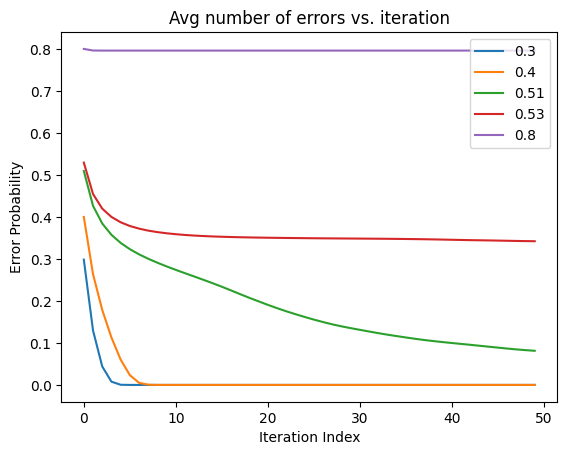

In [20]:
L = [0, -1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0] #Error case
Nsim = 100
probab_erasure = [0.3, 0.4, 0.51, 0.52, 0.8]
for p in probab_erasure:
    avgError = np.zeros(50)
    err_allSim = [0]*Nsim
    for l in range(Nsim):
        originalMsg,errorMsg = generate_msg(p)
        varNodes,chkNodes = initNodes(receivedMsg=errorMsg)
        errorList,decoded_wrd = soft_decode_bec(varNodes,chkNodes)
        # print(errorList)
        err_allSim[l] = errorList

    npError = np.array(err_allSim)
    avgError = np.mean(npError,axis=0)
    # print(avgError)
    plt.plot(np.arange(0, 50), avgError,label=f'{p}')


# print(errorMsg,"\n",npError,"\n",avgError)
plt.title('Avg number of errors vs. iteration')
plt.xlabel('Iteration Index')
plt.ylabel('Error Probability')
plt.legend()
plt.show()
    

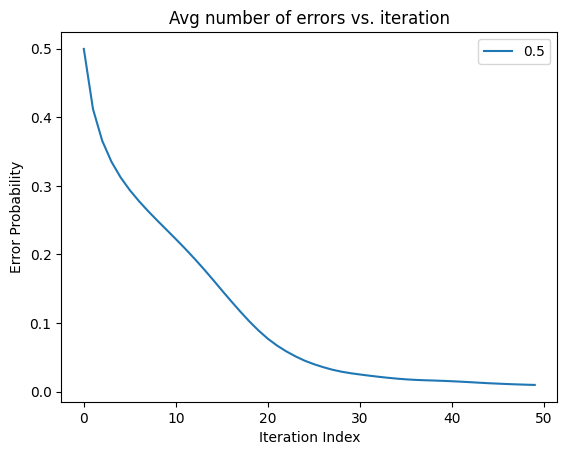

In [21]:
Nsim = 100
probab_erasure = [0.5]
for p in probab_erasure:
    avgError = np.zeros(50)
    err_allSim = [0]*Nsim
    for l in range(Nsim):
        originalMsg,errorMsg = generate_msg(p)
        varNodes,chkNodes = initNodes(receivedMsg=errorMsg)
        errorList,decoded_wrd = soft_decode_bec(varNodes,chkNodes)
        # print(errorList)
        err_allSim[l] = errorList

    npError = np.array(err_allSim)
    avgError = np.mean(npError,axis=0)
    # print(avgError)
    plt.plot(np.arange(0, 50), avgError,label=f'{p}')


# print(errorMsg,"\n",npError,"\n",avgError)
plt.title('Avg number of errors vs. iteration')
plt.xlabel('Iteration Index')
plt.ylabel('Error Probability')
plt.legend()
plt.show()
    